In [12]:
!pip install -r '/content/requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 15.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.6 MB/s eta 0:00:00
  

In [13]:
!pip install transformers==4.40

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [ ]:
import os
os._exit(00)

In [5]:
import os

In [1]:
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from huggingface_hub import snapshot_download

In [6]:
model_name = "THUDM/cogvlm2-llama3-chat-19B-int4"
local_dir = "/content/cogvlm2-llama3-chat-19B-int4"

# Download the model
snapshot_download(repo_id=model_name, local_dir=local_dir, ignore_patterns=["*.md", "*.txt"])

# Verify the download
print(os.listdir(local_dir))

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

['.huggingface', 'config.json', 'generation_config.json', 'configuration_cogvlm.py', 'tokenizer.json', 'LLAMA3_LICENSE', 'LICENSE', 'modeling_cogvlm.py', 'visual.py', 'special_tokens_map.json', 'tokenizer_config.json', 'pytorch_model.bin', 'util.py', '.gitattributes', 'configuration.json']


In [7]:
MODEL_PATH = "/content/cogvlm2-llama3-chat-19B-int4"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'



In [8]:
TORCH_TYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[
    0] >= 8 else torch.float16

TORCH_TYPE

torch.bfloat16

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=TORCH_TYPE,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).eval()

text_only_template = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: {} ASSISTANT:"

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


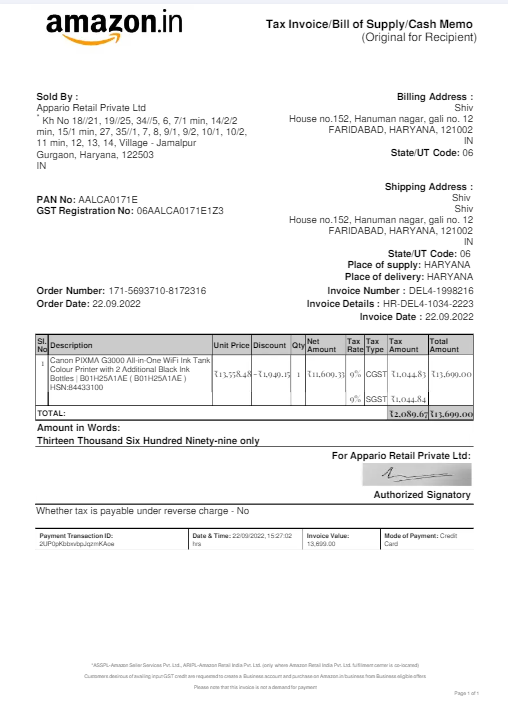

In [11]:
Image.open('/content/Screenshot 2024-07-29 111732.png')

In [13]:
torch.cuda.empty_cache()

In [14]:
while True:
    #image_path = input("image path >>>>> ")
    image_path = r'/content/Screenshot 2024-07-29 111732.png'
    if image_path == '':
        print('You did not enter image path, the following will be a plain text conversation.')
        image = None
        text_only_first_query = True
    else:
        image = Image.open(image_path).convert('RGB')

    history = []

    while True:
        query = input("USER: ")
        if query == "clear":
            break

        if image is None:
            if text_only_first_query:
                query = text_only_template.format(query)
                text_only_first_query = False
            else:
                old_prompt = ''
                for _, (old_query, response) in enumerate(history):
                    old_prompt += old_query + " " + response + "\n"
                query = old_prompt + "USER: {} ASSISTANT:".format(query)
        if image is None:
            input_by_model = model.build_conversation_input_ids(
                tokenizer,
                query=query,
                history=history,
                template_version='chat'
            )
        else:
            input_by_model = model.build_conversation_input_ids(
                tokenizer,
                query=query,
                history=history,
                images=[image],
                template_version='chat'
            )
        inputs = {
            'input_ids': input_by_model['input_ids'].unsqueeze(0).to(DEVICE),
            'token_type_ids': input_by_model['token_type_ids'].unsqueeze(0).to(DEVICE),
            'attention_mask': input_by_model['attention_mask'].unsqueeze(0).to(DEVICE),
            'images': [[input_by_model['images'][0].to(DEVICE).to(TORCH_TYPE)]] if image is not None else None,
        }
        gen_kwargs = {
            "max_new_tokens": 2048,
            "pad_token_id": 128002,
        }
        with torch.no_grad():
            outputs = model.generate(**inputs, **gen_kwargs)
            outputs = outputs[:, inputs['input_ids'].shape[1]:]
            response = tokenizer.decode(outputs[0])
            response = response.split("<|end_of_text|>")[0]
            print("\nCogVLM2:", response)
        history.append((query, response))

USER: Describe this bill to me in a json format

CogVLM2: ```json
{
  "Sold By": "Appario Retail Private Ltd",
  "Billing Address": "Shiv",
  "Shipping Address": "Shiv",
  "PAN No": "AALCA0171E",
  "GST Registration No": "06AALCA0171E1Z3",
  "Order Number": "171-5693710-8172316",
  "Order Date": "22.09.2022",
  "Invoice Details": {
    "Invoice Number": "HR-DEL4-1034-2223",
    "Invoice Date": "22.09.2022"
  },
  "Items": [
    {
      "Sl. No": "1",
      "Description": "Canon PIXMA G3000 All-in-One WiFi Ink Tank Colour Printer with 2 Additional Black Ink Bottles (B01H25A1AE) (B01H25A1AE)",
      "Unit Price": "13,578.48",
      "Discount": "-7,049.13",
      "Qty": "1",
      "Net Amount": "11,609.33",
      "Tax Rate": "9%",
      "CGST": "1,044.84",
      "SGST": "1,044.84",
      "Total Amount": "13,699.00"
    }
  ],
  "Amount in Words": "Thirteen Thousand Six Hundred Ninety-nine only",
  "Payment Transaction ID": "2UP9KBbbwtpjgznKAcce",
  "Date & Time": "22/09/2022, 15:27:02 hrs

KeyboardInterrupt: 